In [1]:
import matplotlib.pyplot as plt
import os, PIL

import numpy as np
np.random.seed(1)

import tensorflow as tf
from tensorflow.keras import layers, models

import pathlib

In [6]:
data_dir = 'hzw_photos'

data_dir = pathlib.Path(data_dir)

In [8]:
image_count = len(list(data_dir.glob('*/*.png')))

print('图片总数为: ', image_count)

图片总数为:  621


In [10]:
batch_size = 32
img_height = 224
img_width = 224

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 621 files belonging to 7 classes.
Using 497 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 621 files belonging to 7 classes.
Using 124 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['lufei', 'luobin', 'namei', 'qiaoba', 'shanzhi', 'suolong', 'wusuopu']


2025-08-09 08:50:44.831411: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


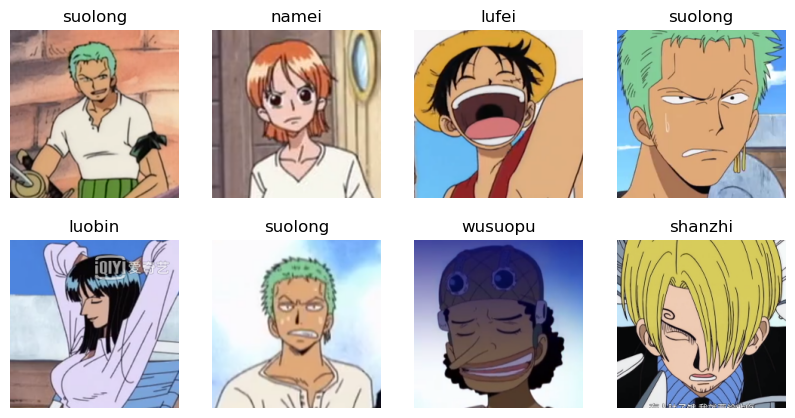

In [24]:
plt.figure(figsize=(10, 5))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)

        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

        plt.axis('off')

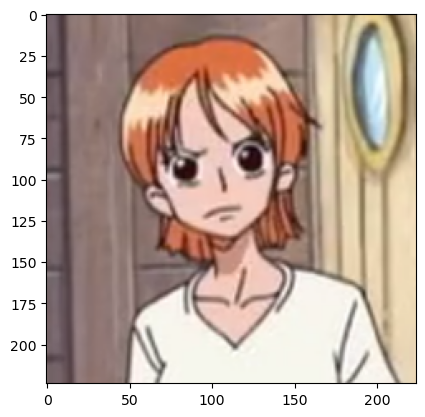

In [28]:
plt.imshow(images[1].numpy().astype('uint8'))

In [30]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
normalization_layer = layers.Rescaling(1./255)

normalization_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [36]:
image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


2025-08-09 08:51:15.011226: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
# 官方调用
# model = keras.application.VGG16()
# model.summary()

In [48]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG16(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # 2nd
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    # 3rd
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    # 4th
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    # 5th
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    # fully connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='predictions')(x)

    model = Model(input_tensor, output_tensor)
    return model

model = VGG16(1000, (img_width, img_height, 3))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,047,848 (507.54 MB)

 Trainable params: 133,047,848 (507.54 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 ━━━━━━━━━━━━━━━━━━━━ 149s 9s/step - accuracy: 0.1590 - loss: 3.4572 - val_accuracy: 0.1935 - val_loss: 6.8657
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - accuracy: 0.3481 - loss: 1.7453 - val_accuracy: 0.2419 - val_loss: 6.8291
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.6419 - loss: 0.9960 - val_accuracy: 0.6048 - val_loss: 6.7874
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 149s 9s/step - accuracy: 0.8229 - loss: 0.5390 - val_accuracy: 0.5726 - val_loss: 6.7987
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.8732 - loss: 0.4162 - val_accuracy: 0.7419 - val_loss: 6.7788
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.9014 - loss: 0.4072 - val_accuracy: 0.7097 - val_loss: 6.8021
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.9155 - loss: 0.2979 - val_accuracy: 0.7258 - val_loss: 6.7671
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - accuracy: 0.9618 - loss: 0.1402 - val_accuracy: 0.7984 - val_loss: 6

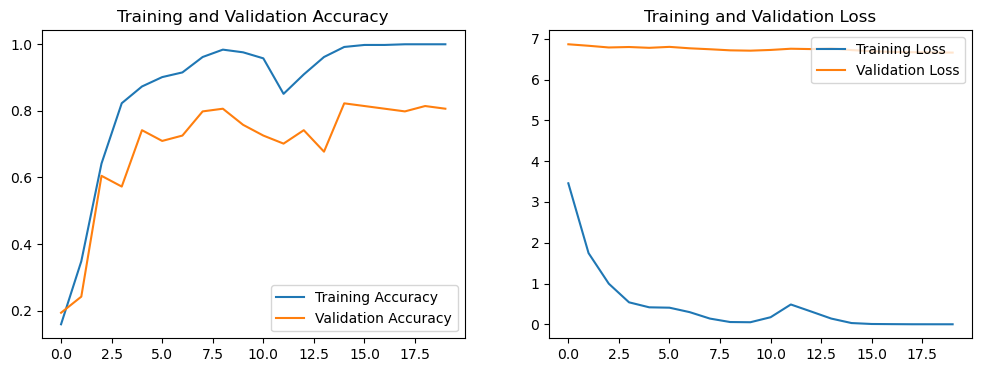

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()